Author: Siyu Zhou

![SNOWFALL](pic/snow.png)

![Q1_1](pic/q1_1.jpg)

In [1]:
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv("Concrete_Data_Yeh.csv")

# Extract independent variables (features)
X = data.iloc[:, :-1].values

# Extract the dependent variable (concrete compressive strength)
Y = data.iloc[:, -1].values.reshape(-1, 1)

# Add a bias term (column of 1s) to X ?? why add 1?
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

# Calculate beta hat (coefficients) using the normal equation
XTX = np.dot(X.T, X)
XTY = np.dot(X.T, Y)
XTX_inv = np.linalg.inv(XTX)
beta_hat = np.dot(XTX_inv, XTY)

# The beta_hat vector contains the coefficients, including the intercept term
beta_intercept = beta_hat[0]  # Intercept term
beta_coefficients = beta_hat[1:]  # Coefficients for the independent variables

print("Intercept (beta0):", beta_intercept)
print("Coefficients (beta1 to beta9):", beta_coefficients)

Intercept (beta0): [-23.33121359]
Coefficients (beta1 to beta9): [[ 0.11980433]
 [ 0.10386581]
 [ 0.08793432]
 [-0.14991842]
 [ 0.2922246 ]
 [ 0.01808621]
 [ 0.02019035]
 [ 0.11422207]]


![Q1_2](pic/q1_2.png)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the dataset into training (75%) and validation (25%) sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

# List of models with different numbers of independent variables
models = [7, 8, 9]
mse_scores = []

# Build and evaluate models
for i in models:
    # Select the first 'i' independent variables
    X_train_i = X_train[:, :i]
    X_val_i = X_val[:, :i]
    
    # Calculate coefficients βˆ for the current model
    beta_hat_i = np.linalg.inv(X_train_i.T @ X_train_i) @ X_train_i.T @ Y_train
    
    # Make predictions
    Y_pred_i = X_val_i @ beta_hat_i
    
    # Calculate MSE for the current model
    mse_i = mean_squared_error(Y_val, Y_pred_i)
    
    mse_scores.append(mse_i)

# Print the MSE scores for each model
for i, mse in enumerate(mse_scores):
    print(f"Model with {models[i]} independent variables: MSE = {mse}")

# Compare the performance of models


Model with 7 independent variables: MSE = 154.82296042191942
Model with 8 independent variables: MSE = 155.31146876294412
Model with 9 independent variables: MSE = 101.58139562951118


I find that in my training result, the model with 9 independent variables perform better that the model only with 7 independent variables, but the model with 7 independent variables has the same performance as the model with 7 independent variables. 
I find that there is not always an improvement in MSE when numbers of features increase(you can see here in my example above), because some features may cause negative effects on predicting values of Y.

![S](pic/q2.png)

![3](pic/q2_1.PNG)

![3](pic/q2_2.PNG)

![3](pic/q2_3.PNG)

![3](pic/q2_4.PNG)

![3](pic/q2_5.PNG)

In [12]:
from pretrained_model.Encoder import extractor
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
# load pretrained model
feature_encoder = extractor()
feature_encoder.load_state_dict(torch.load('pretrained_model/feature_extractor_weights.pth'))
feature_encoder.eval()

extractor(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dim_redu): Sequential(
    (0): Linear(in_features=1568, out_features=256, bias=True)
    (1): Tanh()
  )
)

In [8]:
# Set parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
m = 256
k = 10
n_epochs = 30
lr = 1e-3

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
data1 = datasets.MNIST("./data", train = True, transform = transform, download = True)
data2 = datasets.MNIST("./data", train = False, transform = transform, download = True)
train_data_loader = torch.utils.data.DataLoader(data1, batch_size = batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(data2, batch_size = batch_size, shuffle = False)

In [14]:
w = torch.randn((m, k), device = device)*1e-2
b = torch.randn((k, 1), device = device)*1e-2

# training
with torch.no_grad():
    for idx_epoch in range(n_epochs):
        for data, target in tqdm(train_data_loader, ncols=80):
            data, target = data.to(device), target.to(device)
            eye_matrix = torch.eye(k, device=device)
            y = eye_matrix[target]
            h = feature_encoder(data)

            y_hat = torch.softmax((w.T @ h.T + b).T, dim=1)
            dW = torch.matmul(h.unsqueeze(2), (y_hat - y).unsqueeze(1))
            db = (y_hat - y).unsqueeze(2)
            w = w - lr * dW.mean(dim=0)
            b = b - lr * db.mean(dim=0)
        
        num_correct, num_all, loss = 0, 0, 0.
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            h = feature_encoder(data)
            y_hat = torch.softmax((w.T @ h.T + b).T, dim=1)
            pred_class = torch.argmax(y_hat, dim=1)
            num_correct += torch.sum(pred_class == target)
            num_all += target.shape[0]
            loss += F.cross_entropy(y_hat, target, reduction='sum')
        print('Epoch %d, test accuracy %.4f, loss %.4f' % (idx_epoch, num_correct/num_all, loss/num_all))

100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 175.80it/s]


Epoch 0, test accuracy 0.9834, loss 1.5728


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 176.73it/s]


Epoch 1, test accuracy 0.9853, loss 1.5306


100%|██████████████████████████████████████| 1875/1875 [00:11<00:00, 168.40it/s]


Epoch 2, test accuracy 0.9867, loss 1.5155


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 173.62it/s]


Epoch 3, test accuracy 0.9873, loss 1.5074


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 173.95it/s]


Epoch 4, test accuracy 0.9878, loss 1.5023


100%|██████████████████████████████████████| 1875/1875 [00:11<00:00, 168.05it/s]


Epoch 5, test accuracy 0.9883, loss 1.4987


100%|██████████████████████████████████████| 1875/1875 [00:11<00:00, 166.02it/s]


Epoch 6, test accuracy 0.9884, loss 1.4960


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 170.54it/s]


Epoch 7, test accuracy 0.9885, loss 1.4939


100%|██████████████████████████████████████| 1875/1875 [00:11<00:00, 165.62it/s]


Epoch 8, test accuracy 0.9885, loss 1.4922


100%|██████████████████████████████████████| 1875/1875 [00:11<00:00, 164.88it/s]


Epoch 9, test accuracy 0.9884, loss 1.4908


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 172.92it/s]


Epoch 10, test accuracy 0.9882, loss 1.4897


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 175.95it/s]


Epoch 11, test accuracy 0.9884, loss 1.4886


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 171.63it/s]


Epoch 12, test accuracy 0.9886, loss 1.4878


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 171.43it/s]


Epoch 13, test accuracy 0.9886, loss 1.4870


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 171.05it/s]


Epoch 14, test accuracy 0.9887, loss 1.4863


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 174.87it/s]


Epoch 15, test accuracy 0.9888, loss 1.4857


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 173.83it/s]


Epoch 16, test accuracy 0.9887, loss 1.4851


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 171.86it/s]


Epoch 17, test accuracy 0.9886, loss 1.4846


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 173.38it/s]


Epoch 18, test accuracy 0.9887, loss 1.4841


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 174.11it/s]


Epoch 19, test accuracy 0.9887, loss 1.4837


100%|██████████████████████████████████████| 1875/1875 [00:11<00:00, 160.43it/s]


Epoch 20, test accuracy 0.9888, loss 1.4833


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 172.87it/s]


Epoch 21, test accuracy 0.9889, loss 1.4830


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 174.21it/s]


Epoch 22, test accuracy 0.9891, loss 1.4826


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 176.34it/s]


Epoch 23, test accuracy 0.9891, loss 1.4823


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 176.83it/s]


Epoch 24, test accuracy 0.9891, loss 1.4820


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 184.36it/s]


Epoch 25, test accuracy 0.9892, loss 1.4818


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 183.63it/s]


Epoch 26, test accuracy 0.9892, loss 1.4815


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 174.22it/s]


Epoch 27, test accuracy 0.9891, loss 1.4813


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 180.24it/s]


Epoch 28, test accuracy 0.9891, loss 1.4810


100%|██████████████████████████████████████| 1875/1875 [00:10<00:00, 177.43it/s]


Epoch 29, test accuracy 0.9891, loss 1.4808


![S](pic/q3.png)

![r](pic/q3_2.PNG)

![3](pic/q3_1.PNG)

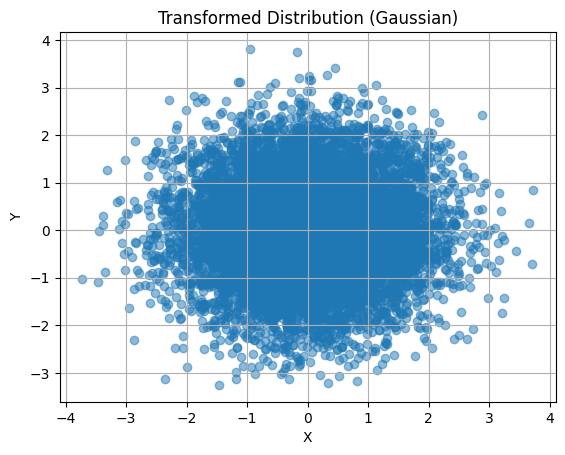

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
num_samples = 10000

# Generate uniform random numbers U1 and U2
U1 = np.random.rand(num_samples)
U2 = np.random.rand(num_samples)

# Compute R and Θ using the Box-Muller transform
R = np.sqrt(-2 * np.log(U2))
Theta = 2 * np.pi * U1

# Transform to Cartesian coordinates
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Create a scatter plot
plt.scatter(X, Y, alpha=0.5)
plt.title('Transformed Distribution (Gaussian)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Show the plot
plt.show()

![S](pic/q4.png)

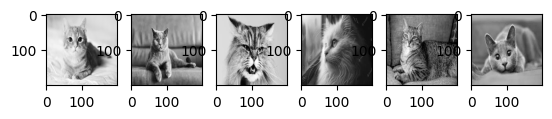

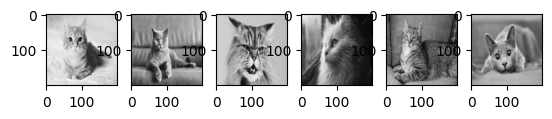

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and display original images
def load_and_display_images(image_paths):
    images = []
    plt.figure()
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        img = img.resize((200,200))
        img = img.convert('L')
        images.append(img)
        plt.subplot(1,6,i+1)
        plt.imshow(img, cmap='gray')
    plt.show()
    return images

# Perform SVD manually
def manual_svd(A):
    # Calculate A^T * A and A * A^T
    ATA = np.matmul(A.T, A)
    AAT = np.matmul(A, A.T)
    
    # Calculate eigenvalues and eigenvectors of ATA
    eigenvalues, V = np.linalg.eig(ATA)
    eigenvalues = eigenvalues.real
    V = V.real
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvalues = np.where(eigenvalues<1e-10, 0, eigenvalues)
    
    sigma = np.sqrt(eigenvalues)
    V = V[:, sorted_indices]
    
    U = np.zeros((len(sigma), len(sigma)))
    for i in range(len(sigma)):
        Ui = A @ V[:, i] / np.clip(sigma[i], 1e-10, 1e20)
        U[:,i] = Ui
        
    return U, sigma, V.T

# Perform SVD compression algorithm
def compress_images(images, k_value):
    compressed_matrices = []
    for img in images:
        # Convert image to grayscale and create the matrix A
        A = np.array(img, dtype=np.float32)
        k = k_value
        
        # Perform manual SVD
        U, S, Vt = manual_svd(A)
        # U, S, Vt = np.linalg.svd(A)
        S1 = np.diag(S[:k])
        
        # Retain only the k largest singular values and vectors
        U1 = U[:, :k]
        Vt1 = Vt[:k, :]
        matrix = (U1, S1, Vt1)
        # Ak = np.dot(U1, np.dot(S1, Vt1)) # why multiple s and vt first?
        compressed_matrices.append(matrix)
        
    return compressed_matrices

# Reconstruct images from compressed matrices
def reconstruct_images(compressed_matrices):
    reconstructed_images = []
    for matrices in compressed_matrices:
        U1 = matrices[0]
        S1 = matrices[1]
        Vt1 = matrices[2]
        
        Ak = np.dot(U1, np.dot(S1, Vt1))
        
        reconstructed_img = Ak
        reconstructed_images.append(reconstructed_img)
    return reconstructed_images        

def display(reconstructed_images):
    plt.figure()
    for i, image in enumerate(reconstructed_images):
        plt.subplot(1,6,i+1)
        plt.imshow(image, cmap='gray')
    plt.show()
        

# Paths to original images
image_paths = ['pic/cat1.jpeg', 'pic/cat2.jpeg', 'pic/cat3.jpeg', 'pic/cat4.jpeg', 'pic/cat5.jpeg', 'pic/cat6.jpeg']

# Number of singular values to retain for compression (adjust as needed)
k_values = 40

# Load and display original images
original_images = load_and_display_images(image_paths)

# Perform SVD compression
compressed_matrices = compress_images(original_images, k_values)

# Reconstruct images from compressed matrices
reconstructed_images = reconstruct_images(compressed_matrices)

# Display original, compressed, and reconstructed images
display(reconstructed_images)

In [97]:
print(compressed_matrices)

[(array([[-0.07346079, -0.05846011,  0.10117697, ...,  0.04517826,
         0.0462606 , -0.02671672],
       [-0.07337767, -0.05871433,  0.10071993, ...,  0.0530459 ,
         0.05132537, -0.0303797 ],
       [-0.0732921 , -0.05888429,  0.10006861, ...,  0.05008715,
         0.04764761, -0.02310385],
       ...,
       [-0.07897881, -0.03948685,  0.08234722, ...,  0.00495984,
         0.03987864, -0.07375243],
       [-0.0793687 , -0.03937112,  0.08418889, ..., -0.02327915,
        -0.0681387 , -0.09332421],
       [-0.07957061, -0.03821695,  0.08888061, ..., -0.04253275,
        -0.129866  , -0.1207009 ]]), array([[38178.484  ,     0.     ,     0.     , ...,     0.     ,
            0.     ,     0.     ],
       [    0.     ,  6367.236  ,     0.     , ...,     0.     ,
            0.     ,     0.     ],
       [    0.     ,     0.     ,  3347.1511 , ...,     0.     ,
            0.     ,     0.     ],
       ...,
       [    0.     ,     0.     ,     0.     , ...,   166.47993,
       